<a href="https://colab.research.google.com/github/karolinakuligowska/Projektowanie_systemow_informatycznych/blob/main/PSI_Zaj_6_5_Text_mining_BoW__Pe%C5%82na_analiza_jednego_pliku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wymagane pakiety

In [1]:
install.packages("SentimentAnalysis")

Installing package into ‚Äò/usr/local/lib/R/site-library‚Äô
(as ‚Äòlib‚Äô is unspecified)

also installing the dependencies ‚Äòiterators‚Äô, ‚ÄòNLP‚Äô, ‚Äòslam‚Äô, ‚ÄòBH‚Äô, ‚Äòtau‚Äô, ‚Äòforeach‚Äô, ‚Äòshape‚Äô, ‚ÄòRcppEigen‚Äô, ‚Äòlars‚Äô, ‚ÄòrandomForest‚Äô, ‚Äòtm‚Äô, ‚ÄòqdapDictionaries‚Äô, ‚Äòngramrr‚Äô, ‚Äòmoments‚Äô, ‚Äòstringdist‚Äô, ‚Äòglmnet‚Äô, ‚Äòspikeslab‚Äô




In [2]:
install.packages(c("tm", "tidytext", "stringr", "wordcloud", "RColorBrewer", "ggplot2", "SnowballC", "ggthemes", "tidyverse"))

Installing packages into ‚Äò/usr/local/lib/R/site-library‚Äô
(as ‚Äòlib‚Äô is unspecified)

also installing the dependencies ‚Äòjaneaustenr‚Äô, ‚Äòtokenizers‚Äô




In [7]:
library(tm)
library(tidytext)
library(stringr)
library(wordcloud)
library(RColorBrewer)
library(ggplot2)
library(SnowballC)
library(SentimentAnalysis)
library(ggthemes)
library(tidyverse)

Loading required package: NLP

Loading required package: RColorBrewer


Attaching package: ‚Äòggplot2‚Äô


The following object is masked from ‚Äòpackage:NLP‚Äô:

    annotate



Attaching package: ‚ÄòSentimentAnalysis‚Äô


The following object is masked from ‚Äòpackage:base‚Äô:

    write


‚îÄ‚îÄ Attaching core tidyverse packages ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ tidyverse 2.0.0 ‚îÄ‚îÄ
‚úî dplyr     1.1.4     ‚úî readr     2.1.5
‚úî forcats   1.0.0     ‚úî tibble    3.2.1
‚úî lubridate 1.9.4     ‚úî tidyr     1.3.1
‚úî purrr     1.0.4     
‚îÄ‚îÄ Conflicts ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ tidyverse_conflicts() ‚îÄ‚îÄ
‚úñ ggplot2::annotate() masks NLP::annotate()
‚úñ dplyr::filter()     masks stats::filter()
‚úñ dplyr::lag()        masks stats::lag()
‚Ñπ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# 0. Funkcja do przetwarzania tekstu z apostrofami, stemmingiem i stemCompletion

In [3]:
process_text <- function(file_path) {
  text <- tolower(readLines(file_path, encoding = "UTF-8"))
  text <- gsub("[\u2019\u2018\u0060\u00B4]", "'", text)
  text <- removeNumbers(text)
  words <- unlist(strsplit(text, "\\s+"))
  words <- words[words != ""]
  words <- words[!str_detect(words, "'")]
  words <- str_replace_all(words, "[[:punct:]]", "")
  words <- words[words != ""]
  words <- str_trim(words)

  tidy_stopwords <- tolower(stop_words$word)
  tidy_stopwords <- gsub("[\u2019\u2018\u0060\u00B4]", "'", tidy_stopwords)
  tm_stopwords <- tolower(stopwords("en"))
  tm_stopwords <- gsub("[\u2019\u2018\u0060\u00B4]", "'", tm_stopwords)

  words <- words[!(words %in% tidy_stopwords)]
  words <- words[!(words %in% tm_stopwords)]

  # Stemming + stem completion
  stemmed_doc <- stemDocument(words)
  completed_doc <- stemCompletion(stemmed_doc, dictionary=words, type="prevalent")
  completed_doc <- completed_doc[completed_doc != ""]

  return(completed_doc)
}

# 0. Funkcja do obliczania czƒôsto≈õci wystƒôpowania s≈Ç√≥w ----

In [4]:
word_frequency <- function(words) {
  freq <- table(words)
  freq_df <- data.frame(word = names(freq), freq = as.numeric(freq))
  freq_df <- freq_df[order(-freq_df$freq), ]
  return(freq_df)
}

# 0. Funkcja do tworzenia chmury s≈Ç√≥w ----

In [5]:
plot_wordcloud <- function(freq_df, title, color_palette = "Dark2") {
  wordcloud(words = freq_df$word, freq = freq_df$freq, min.freq = 16,
            colors = brewer.pal(8, color_palette))
  title(title)
}

# ANALIZA TEXT MINING

### üìå Przetwarzanie i oczyszczanie tekstu <br>*(Text Preprocessing and Text Cleaning)*

- wczytanie tekstu z odpowiednim kodowaniem (UTF-8)
- normalizacja (ujednolicenie) wielko≈õci liter (zamiana na ma≈Çe litery = lowercase)
- normalizacja (ujednolicenie) rozbie≈ºnych kodowa≈Ñ znak√≥w (apostrofy, cudzys≈Çowy)
- normalizacja (ujednolicenie) form skr√≥conych (I'm, I've, don't) przez usuniƒôcie lub rozwiniƒôcie
- normalizacja (ujednolicenie) r√≥≈ºnych akcent√≥w ("caf√©" na "cafe") przez usuniƒôcie akcent√≥w
- normalizacja (ujednolicenie) popularnych skr√≥t√≥w ("btw" na "by the way", "b4" na "before") przez rozwiniƒôcie
- usuniƒôcie zbƒôdnych ciƒÖg√≥w znak√≥w (adresy URL, tagi HTML)
- usuniƒôcie zbƒôdnych znak√≥w specjalnych (*, &, #, @, $)
- usuniƒôcie zbƒôdnych bia≈Çych znak√≥w (spacja, tabulacja, znak przej≈õcia do nowej linii "enter")
- usuniƒôcie cyfr i liczb
- usuniƒôcie interpunkcji
- tokenizacja (podzia≈Ç tekstu na s≈Çowa = tokeny)
- usuniƒôcie stopwords (s≈Ç√≥w o ma≈Çej warto≈õci semantycznej, np. "the", "and")
- usuniƒôcie pustych element√≥w (rozwa≈ºenie problemu brakujƒÖcych/niekompletnych danych )
- stemming lub lematyzacja (sprowadzenie s≈Ç√≥w do ich rdzenia/formy podstawowej)

### üìå Zliczanie czƒôsto≈õci s≈Ç√≥w <br>*(Word Frequency Count)*

### üìå Eksploracyjna analiza danych: <br>wizualizacja czƒôsto≈õci s≈Ç√≥w (tabela, wykres, chmura s≈Ç√≥w) <br>*(Exploratory Data Analysis, EDA)*

### üìå In≈ºynieria cech w modelu Bag of Words: <br>reprezentacja tekstu jako zbioru s≈Ç√≥w i czƒôsto≈õci s≈Ç√≥w ( = cechy) <br>*(Feature Engineering in BoW model)*

In [8]:
# Wczytanie i przetworzenie tekstu
# file_path <- "sciezka/do/pliku.txt"  <= Uzupe≈Çnij nazwƒô pliku i ustaw Working Directory!
file_path <- "Trump2025.txt"
words <- process_text(file_path)


# Dodatkowe niestandardowe stopwords
custom_stopwords <- c("$")
words <- words[!words %in% custom_stopwords]


# Czƒôsto≈õƒá s≈Ç√≥w
freq_df <- word_frequency(words)

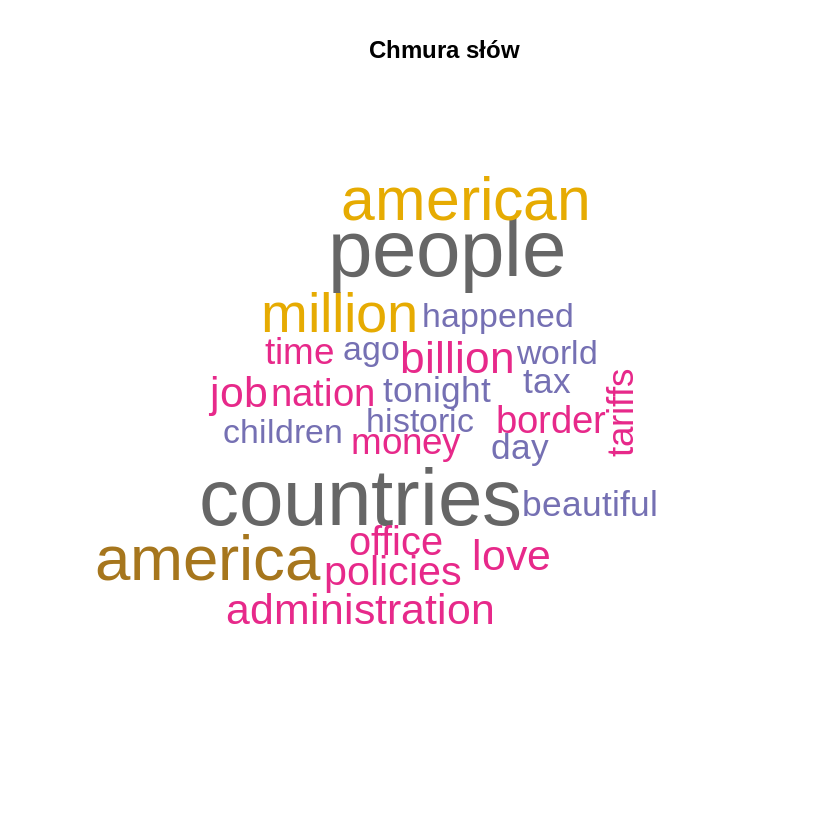

In [9]:
# Chmura s≈Ç√≥w
plot_wordcloud(freq_df, "Chmura s≈Ç√≥w", "Dark2")


In [10]:
# Wy≈õwietl top 10
print(head(freq_df, 10))

              word freq
245      countries   47
820         people   47
47         america   36
48        american   34
732        million   31
115        billion   23
19  administration   22
613            job   22
691           love   22
844       policies   21


# Analiza sentymentu s≈Çowniki CSV ----

## Wczytaj s≈Çowniki z plik√≥w csv ----

In [11]:
afinn <- read.csv("afinn.csv", stringsAsFactors = FALSE)
bing <- read.csv("bing.csv", stringsAsFactors = FALSE)
loughran <- read.csv("loughran.csv", stringsAsFactors = FALSE)
nrc <- read.csv("nrc.csv", stringsAsFactors = FALSE)

In [12]:
tidy_tokeny <- as_tibble(freq_df)

## Analiza sentymentu przy u≈ºyciu s≈Çownika Loughran ----

In [15]:
# U≈ºycie inner_join()
tidy_tokeny %>%
  inner_join(loughran, relationship = "many-to-many")
# Liczba s≈Ç√≥w drastycznie siƒô zmniejszy≈Ça,
# poniewa≈º inner_join zachowa≈Ç tylko te s≈Çowa,
# kt√≥re wystƒôpowa≈Çy w s≈Çowniku


# Zliczanie sentymentu
sentiment_review <- tidy_tokeny %>%
  inner_join(loughran, relationship = "many-to-many")

sentiment_review %>%
  count(sentiment)


# Zliczanie, kt√≥re s≈Çowa sƒÖ najczƒôstsze
# dla danego sentymentu
sentiment_review %>%
  group_by(sentiment) %>%
  arrange(desc(freq)) %>%
  ungroup()

# Filtrowanie analizy sentymentu
# i pozostawienie tylko s≈Ç√≥w
# o sentymencie pozytywnym lub negatywnym

sentiment_review2 <- sentiment_review %>%
  filter(sentiment %in% c("positive", "negative"))


word_counts <- sentiment_review2 %>%
  group_by(sentiment) %>%
  top_n(20, freq) %>%
  ungroup() %>%
  arrange(desc(freq), word) %>%
  mutate(
    word2 = factor(word, levels = rev(unique(word)))
    )

Joining with `by = join_by(word)`


word         freq sentiment   
1   beautiful    17   positive    
2   law          12   litigious   
3   dangerous    11   negative    
4   bad           9   negative    
5   strong        9   positive    
6   arrests       8   negative    
7   illegal       8   negative    
8   successful    8   positive    
9   criminal      7   negative    
10  criminal      7   litigious   
11  dream         7   positive    
12  happiness     6   positive    
13  incredible    6   positive    
14  tremendous    6   positive    
15  destroy       5   negative    
16  incompetence  5   negative    
17  regulations   5   litigious   
18  achieved      4   positive    
19  brilliant     4   positive    
20  crime         4   negative    
21  crime         4   litigious   
22  forced        4   negative    
23  fraud         4   negative    
24  hurt          4   negative    
25  mandate       4   constraining
26  wrong         4   negative    
27  defending     3   negative    
28  deficits      3   negative    
29  exposed       3   negative    
30  fantastic     3   positive    
‚ãÆ   ‚ãÆ            ‚ãÆ    ‚ãÆ           
99  leadership   1    positive    
100 lose         1    negative    
101 lost         1    negative    
102 perfect      1    positive    
103 permitting   1    constraining
104 pleasant     1    positive    
105 probable     1    uncertainty 
106 prosecute    1    negative    
107 prosecute    1    litigious   
108 prosperous   1    positive    
109 reject       1    negative    
110 requiring    1    constraining
111 restrictions 1    constraining
112 risk         1    uncertainty 
113 sentenced    1    negative    
114 sentenced    1    litigious   
115 severely     1    negative    
116 slowed       1    negative    
117 spectacular  1    positive    
118 stolen       1    negative    
119 stoppage     1    negative    
120 strength     1    positive    
121 suffered     1    negative    
122 threaten     1    negative    
123 tragically   1    negative    
124 traumatic    1    negative    
125 trouble      1    negative    
126 unknown      1    uncertainty 
127 violated     1    negative    
128 whatsoever   1    litigious

Joining with `by = join_by(word)`


sentiment    n 
1 constraining  5
2 litigious    14
3 negative     69
4 positive     35
5 uncertainty   5

word         freq sentiment   
1   beautiful    17   positive    
2   law          12   litigious   
3   dangerous    11   negative    
4   bad           9   negative    
5   strong        9   positive    
6   arrests       8   negative    
7   illegal       8   negative    
8   successful    8   positive    
9   criminal      7   negative    
10  criminal      7   litigious   
11  dream         7   positive    
12  happiness     6   positive    
13  incredible    6   positive    
14  tremendous    6   positive    
15  destroy       5   negative    
16  incompetence  5   negative    
17  regulations   5   litigious   
18  achieved      4   positive    
19  brilliant     4   positive    
20  crime         4   negative    
21  crime         4   litigious   
22  forced        4   negative    
23  fraud         4   negative    
24  hurt          4   negative    
25  mandate       4   constraining
26  wrong         4   negative    
27  defending     3   negative    
28  deficits      3   negative    
29  exposed       3   negative    
30  fantastic     3   positive    
‚ãÆ   ‚ãÆ            ‚ãÆ    ‚ãÆ           
99  leadership   1    positive    
100 lose         1    negative    
101 lost         1    negative    
102 perfect      1    positive    
103 permitting   1    constraining
104 pleasant     1    positive    
105 probable     1    uncertainty 
106 prosecute    1    negative    
107 prosecute    1    litigious   
108 prosperous   1    positive    
109 reject       1    negative    
110 requiring    1    constraining
111 restrictions 1    constraining
112 risk         1    uncertainty 
113 sentenced    1    negative    
114 sentenced    1    litigious   
115 severely     1    negative    
116 slowed       1    negative    
117 spectacular  1    positive    
118 stolen       1    negative    
119 stoppage     1    negative    
120 strength     1    positive    
121 suffered     1    negative    
122 threaten     1    negative    
123 tragically   1    negative    
124 traumatic    1    negative    
125 trouble      1    negative    
126 unknown      1    uncertainty 
127 violated     1    negative    
128 whatsoever   1    litigious

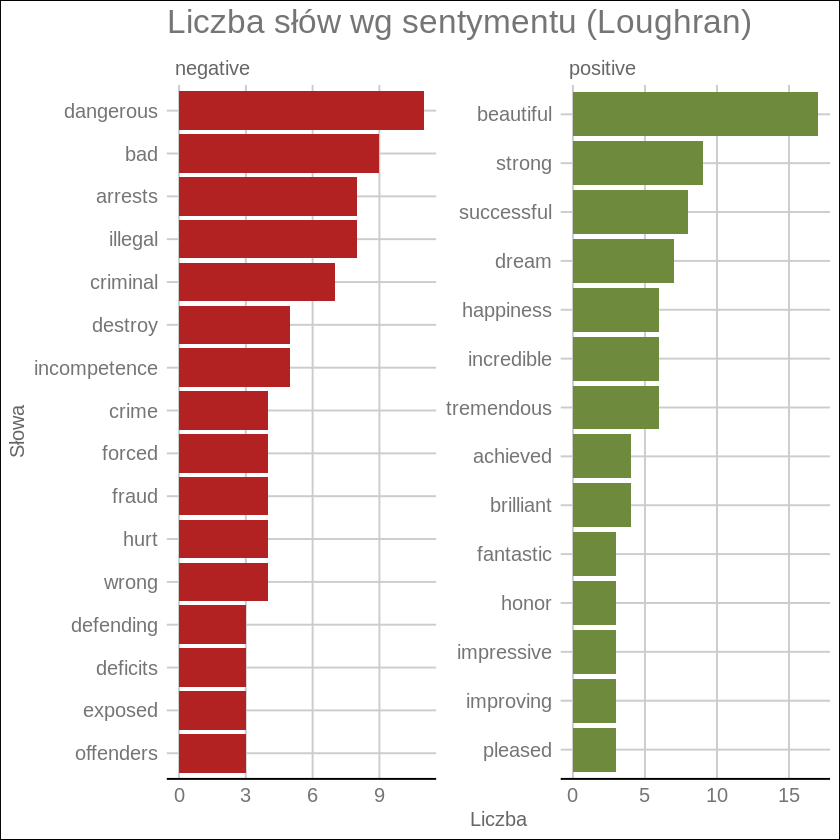

In [16]:
# Wizualizacja sentymentu
ggplot(word_counts[1:30,], aes(x=word2, y=freq, fill=sentiment)) +
  geom_col(show.legend=FALSE) +
  facet_wrap(~sentiment, scales="free") +
  coord_flip() +
  labs(x = "S≈Çowa", y = "Liczba") +
  theme_gdocs() +
  ggtitle("Liczba s≈Ç√≥w wg sentymentu (Loughran)") +
  scale_fill_manual(values = c("firebrick", "darkolivegreen4"))

## Analiza sentymentu przy u≈ºyciu s≈Çownika NRC ----

In [18]:
# Zliczanie sentymentu
sentiment_review_nrc <- tidy_tokeny %>%
  inner_join(nrc, relationship = "many-to-many")

sentiment_review_nrc %>%
  count(sentiment)

# Zliczanie, kt√≥re s≈Çowa sƒÖ najczƒôstsze
# dla danego sentymentu
sentiment_review_nrc %>%
  group_by(sentiment) %>%
  arrange(desc(freq)) %>%
  ungroup()

# Filtrowanie analizy sentymentu
# i pozostawienie tylko s≈Ç√≥w
# o sentymencie pozytywnym lub negatywnym

sentiment_review_nrc2 <- sentiment_review_nrc %>%
  filter(sentiment %in% c("positive", "negative"))


word_counts_nrc2 <- sentiment_review_nrc2 %>%
  group_by(sentiment) %>%
  top_n(20, freq) %>%
  ungroup() %>%
  arrange(desc(freq), word) %>%
  mutate(
    word2 = factor(word, levels = rev(unique(word)))
    )

Joining with `by = join_by(word)`


sentiment    n  
1  anger         82
2  anticipation  84
3  disgust       53
4  fear         101
5  joy           68
6  negative     136
7  positive     173
8  sadness       65
9  surprise      45
10 trust        107

word       freq sentiment   
1   job        22   positive    
2   love       22   joy         
3   love       22   positive    
4   nation     19   trust       
5   money      18   anger       
6   money      18   anticipation
7   money      18   joy         
8   money      18   positive    
9   money      18   surprise    
10  money      18   trust       
11  time       18   anticipation
12  beautiful  17   joy         
13  beautiful  17   positive    
14  tax        17   negative    
15  tax        17   sadness     
16  president  14   positive    
17  president  14   trust       
18  united     13   positive    
19  united     13   trust       
20  law        12   trust       
21  protect    12   positive    
22  dangerous  11   fear        
23  dangerous  11   negative    
24  building   10   positive    
25  fight      10   anger       
26  fight      10   fear        
27  fight      10   negative    
28  pay        10   anticipation
29  pay        10   joy         
30  pay        10   positive    
‚ãÆ   ‚ãÆ          ‚ãÆ    ‚ãÆ           
885 usher      1    trust       
886 verge      1    anticipation
887 verge      1    fear        
888 verge      1    negative    
889 veteran    1    positive    
890 veteran    1    trust       
891 victim     1    anger       
892 victim     1    fear        
893 victim     1    negative    
894 victim     1    sadness     
895 vital      1    positive    
896 volunteer  1    anticipation
897 volunteer  1    fear        
898 volunteer  1    joy         
899 volunteer  1    positive    
900 volunteer  1    trust       
901 wealth     1    joy         
902 wealth     1    positive    
903 wealth     1    trust       
904 welcomed   1    joy         
905 welcomed   1    positive    
906 wilderness 1    anticipation
907 wilderness 1    fear        
908 wilderness 1    sadness     
909 youth      1    anger       
910 youth      1    anticipation
911 youth      1    fear        
912 youth      1    joy         
913 youth      1    positive    
914 youth      1    surprise

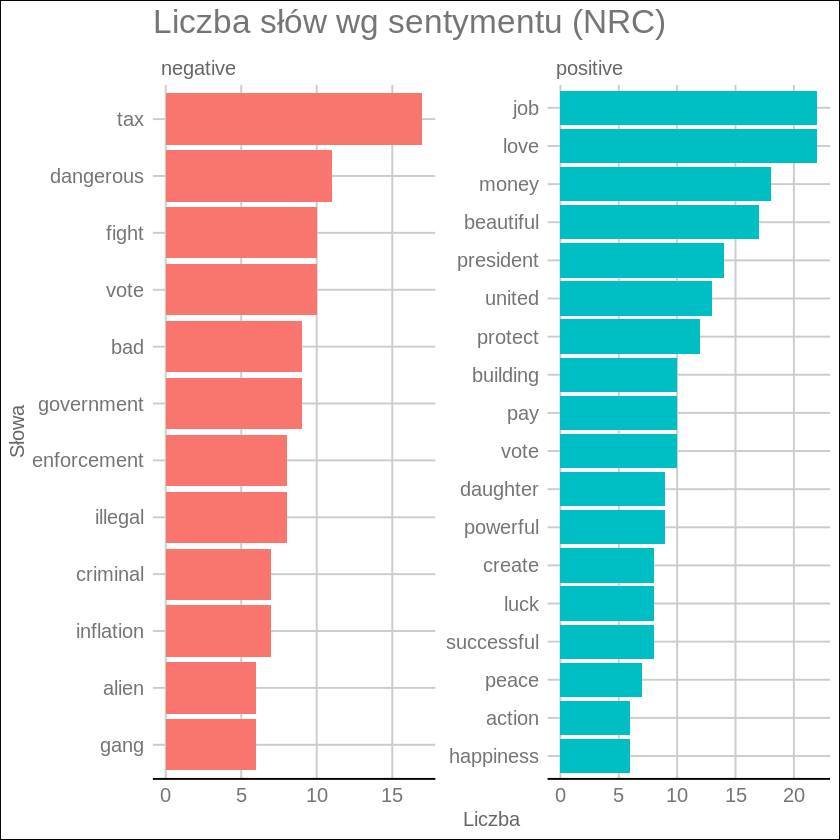

In [17]:
# Wizualizacja sentymentu
ggplot(word_counts_nrc2[1:30,], aes(x=word2, y=freq, fill=sentiment)) +
  geom_col(show.legend=FALSE) +
  facet_wrap(~sentiment, scales="free") +
  coord_flip() +
  labs(x = "S≈Çowa", y = "Liczba") +
  theme_gdocs() +
  ggtitle("Liczba s≈Ç√≥w wg sentymentu (NRC)")

## Analiza sentymentu przy u≈ºyciu s≈Çownika Bing ----

In [19]:
# Zliczanie sentymentu
sentiment_review_bing <- tidy_tokeny %>%
  inner_join(bing)

sentiment_review_bing %>%
  count(sentiment)

# Zliczanie, kt√≥re s≈Çowa sƒÖ najczƒôstsze
# dla danego sentymentu
sentiment_review_bing %>%
  group_by(sentiment) %>%
  arrange(desc(freq)) %>%
  ungroup()

# Filtrowanie analizy sentymentu
# i pozostawienie tylko s≈Ç√≥w
# o sentymencie pozytywnym lub negatywnym

sentiment_review_bing2 <- sentiment_review_bing %>%
  filter(sentiment %in% c("positive", "negative"))


word_counts_bing2 <- sentiment_review_bing2 %>%
  group_by(sentiment) %>%
  top_n(20, freq) %>%
  ungroup() %>%
  arrange(desc(freq), word) %>%
  mutate(
    word2 = factor(word, levels = rev(unique(word)))
    )

Joining with `by = join_by(word)`


sentiment n  
1 negative  110
2 positive  114

word          freq sentiment
1   love          22   positive 
2   beautiful     17   positive 
3   protect       12   positive 
4   dangerous     11   negative 
5   hard          10   negative 
6   bad            9   negative 
7   killed         9   negative 
8   powerful       9   positive 
9   strong         9   positive 
10  illegal        8   negative 
11  luck           8   positive 
12  successful     8   positive 
13  criminal       7   negative 
14  peace          7   positive 
15  golden         6   positive 
16  happiness      6   positive 
17  incredible     6   positive 
18  debt           5   negative 
19  destroy        5   negative 
20  died           5   negative 
21  fast           5   positive 
22  free           5   positive 
23  incompetence   5   negative 
24  respect        5   positive 
25  top            5   positive 
26  won            5   positive 
27  brilliant      4   positive 
28  crime          4   negative 
29  fraud          4   negative 
30  horrible       4   negative 
‚ãÆ   ‚ãÆ             ‚ãÆ    ‚ãÆ        
195 sick          1    negative 
196 skill         1    positive 
197 slashing      1    negative 
198 slowed        1    negative 
199 smile         1    positive 
200 sophisticated 1    positive 
201 spectacular   1    positive 
202 stolen        1    negative 
203 suffered      1    negative 
204 superstitious 1    negative 
205 supreme       1    positive 
206 sweetheart    1    positive 
207 threaten      1    negative 
208 thrilling     1    positive 
209 thug          1    negative 
210 torture       1    negative 
211 tougher       1    positive 
212 toughest      1    positive 
213 toxic         1    negative 
214 tragically    1    negative 
215 trapped       1    negative 
216 traumatic     1    negative 
217 treasure      1    positive 
218 trouble       1    negative 
219 unaffordable  1    negative 
220 unknown       1    negative 
221 unlimited     1    positive 
222 unrelenting   1    negative 
223 vain          1    negative 
224 wow           1    positive

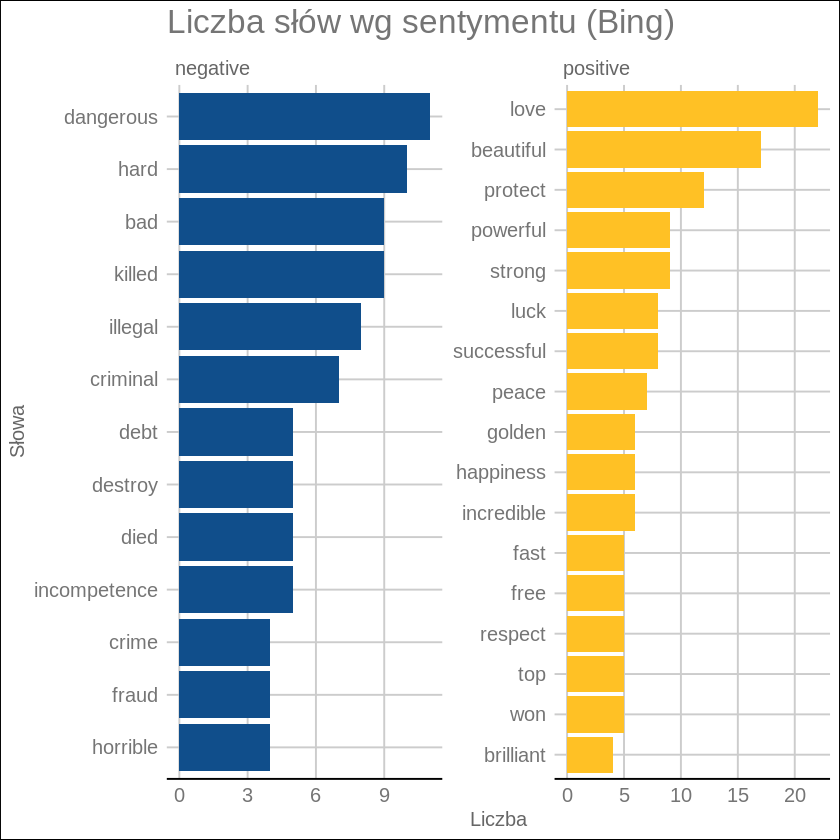

In [20]:
# Wizualizacja sentymentu
ggplot(word_counts_bing2[1:30,], aes(x=word2, y=freq, fill=sentiment)) +
  geom_col(show.legend=FALSE) +
  facet_wrap(~sentiment, scales="free") +
  coord_flip() +
  labs(x = "S≈Çowa", y = "Liczba") +
  theme_gdocs() +
  ggtitle("Liczba s≈Ç√≥w wg sentymentu (Bing)") +
  scale_fill_manual(values = c("dodgerblue4", "goldenrod1"))

## Analiza sentymentu przy u≈ºyciu s≈Çownika Afinn ----

In [21]:
# Zliczanie sentymentu
sentiment_review_afinn <- tidy_tokeny %>%
  inner_join(afinn)

sentiment_review_afinn %>%
  count(value)

# Zliczanie, kt√≥re s≈Çowa sƒÖ najczƒôstsze
# dla danego sentymentu
sentiment_review_afinn %>%
  group_by(value) %>%
  arrange(desc(freq)) %>%
  ungroup()

# Silnie pozytywne lub silnie negatywne s≈Çowa:
# filtrowanie analizy sentymentu
# i pozostawienie tylko s≈Ç√≥w o warto≈õci w zakresie od -5 do 5

sentiment_review_afinn3 <- sentiment_review_afinn %>%
  filter(value %in% c("3", "-3" , "4", "-4", "5", "-5"))


word_counts_afinn3 <- sentiment_review_afinn3 %>%
  group_by(value) %>%
  top_n(20, freq) %>%
  ungroup() %>%
  arrange(desc(freq), word) %>%
  mutate(
    word2 = factor(word, levels = rev(unique(word)))
    )

Joining with `by = join_by(word)`


value n 
1 -4     3
2 -3    26
3 -2    47
4 -1    25
5  1    27
6  2    45
7  3    22
8  4     6

word          freq value
1   love          22    3   
2   beautiful     17    3   
3   united        13    1   
4   protect       12    1   
5   fight         10   -1   
6   hard          10   -1   
7   pay           10   -1   
8   stop          10   -1   
9   bad            9   -3   
10  cuts           9   -1   
11  killed         9   -3   
12  powerful       9    2   
13  strong         9    2   
14  arrests        8   -2   
15  illegal        8   -3   
16  luck           8    3   
17  successful     8    3   
18  criminal       7   -3   
19  dream          7    1   
20  peace          7    2   
21  happiness      6    3   
22  saved          6    2   
23  debt           5   -2   
24  destroy        5   -3   
25  died           5   -3   
26  fire           5   -2   
27  forget         5   -1   
28  free           5    1   
29  incompetence   5   -2   
30  lowest         5   -1   
‚ãÆ   ‚ãÆ             ‚ãÆ    ‚ãÆ    
172 poised        1    -2   
173 prison        1    -2   
174 propaganda    1    -2   
175 prosecute     1    -1   
176 prosperous    1     3   
177 rape          1    -4   
178 reach         1     1   
179 reject        1    -1   
180 rescue        1     2   
181 responsible   1     2   
182 risk          1    -2   
183 sentenced     1    -2   
184 shocking      1    -2   
185 sick          1    -2   
186 slashing      1    -2   
187 smile         1     2   
188 sophisticated 1     2   
189 stolen        1    -2   
190 strength      1     2   
191 threaten      1    -2   
192 torture       1    -4   
193 trapped       1    -2   
194 traumatic     1    -3   
195 treasure      1     2   
196 trouble       1    -2   
197 victim        1    -3   
198 violated      1    -2   
199 wealth        1     3   
200 welcomed      1     2   
201 wow           1     4

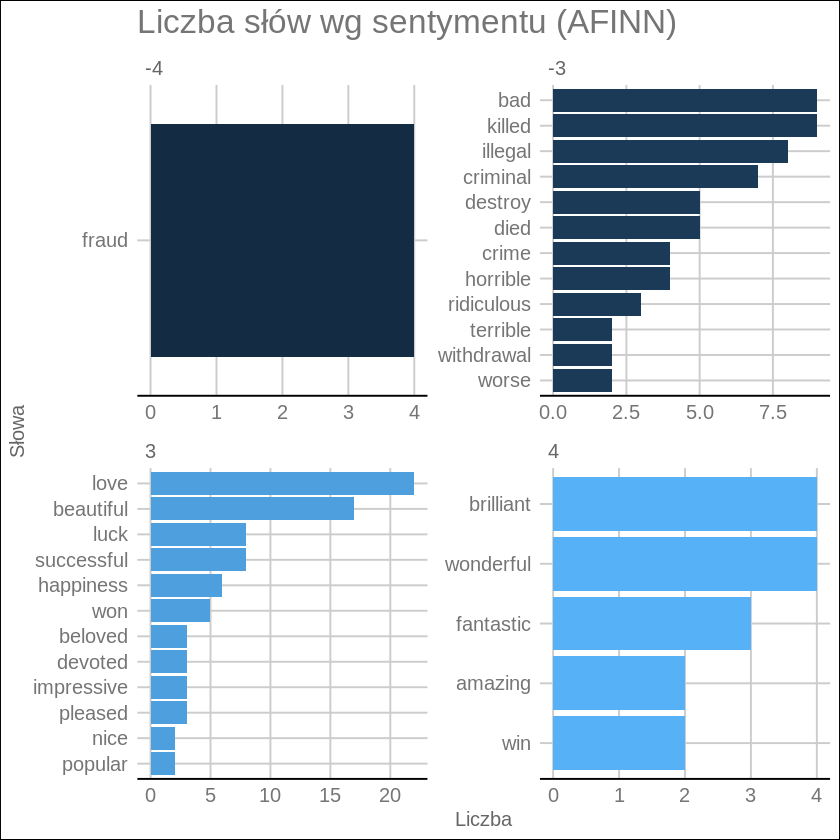

In [22]:
# Wizualizacja sentymentu
ggplot(word_counts_afinn3[1:30,], aes(x=word2, y=freq, fill=value)) +
  geom_col(show.legend=FALSE) +
  facet_wrap(~value, scales="free") +
  coord_flip() +
  labs(x = "S≈Çowa", y = "Liczba") +
  theme_gdocs() +
  ggtitle("Liczba s≈Ç√≥w wg sentymentu (AFINN)")

# Analiza sentymentu w czasie o ustalonej d≈Çugo≈õci linii ----

In [23]:
# Po≈ÇƒÖczenie wszystkich s≈Ç√≥w words w jeden ciƒÖg znak√≥w
full_text <- paste(words, collapse = " ")


# Funkcja do dzielenia tekstu na segmenty o okre≈õlonej d≈Çugo≈õci
split_text_into_chunks <- function(text, chunk_size) {
  start_positions <- seq(1, nchar(text), by = chunk_size)
  chunks <- substring(text, start_positions, start_positions + chunk_size - 1)
  return(chunks)
}


# Podzielenie tekstu na segmenty
#
# ustaw min_lentgh jako jednolitƒÖ d≈Çugo≈õƒá jednego segmentu
set_length <- 50
text_chunks <- split_text_into_chunks(full_text, set_length)


# Wy≈õwietlenie wynikowych segment√≥w
# print(text_chunks)

# Analiza sentymentu przy u≈ºyciu pakietu SentimentAnalysis ----

In [24]:
sentiment <- analyzeSentiment(text_chunks)

### S≈Çownik GI (General Inquirer) ----

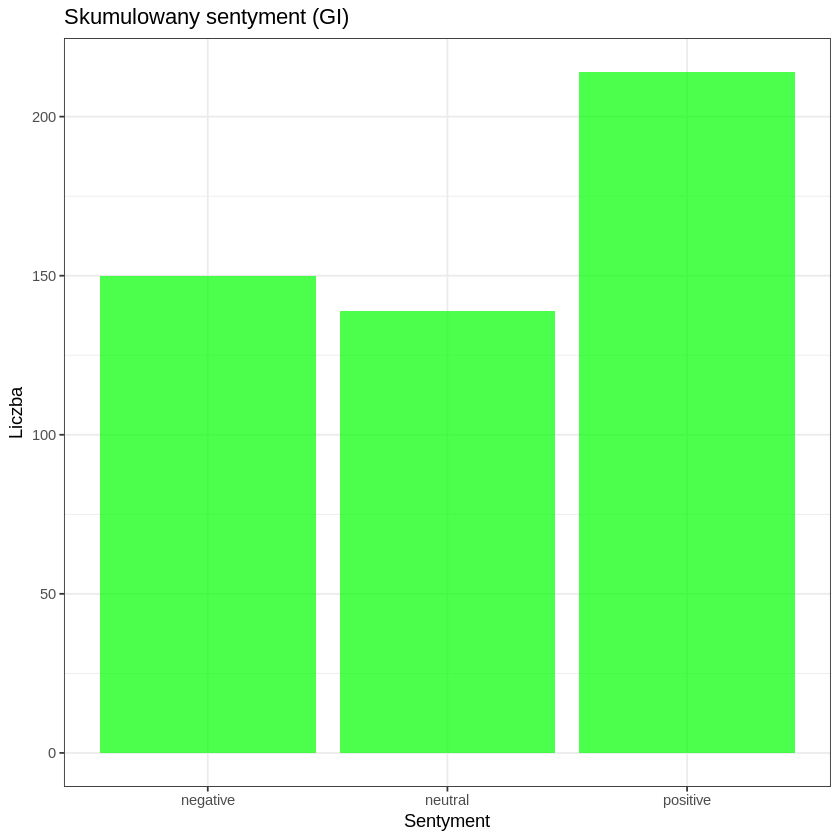

In [25]:
### S≈Çownik GI (General Inquirer) ----
#
# S≈Çownik og√≥lnego zastosowania
# zawiera listƒô s≈Ç√≥w pozytywnych i negatywnych
# zgodnych z psychologicznym s≈Çownikiem harwardzkim Harvard IV-4
# DictionaryGI


# Wczytaj s≈Çownik GI
# data(DictionaryGI)
# summary(DictionaryGI)


# Konwersja ciƒÖg≈Çych warto≈õci sentymentu
# na odpowiadajƒÖce im warto≈õci kierunkowe
# zgodnie ze s≈Çownikiem GI
sentimentGI <- convertToDirection(sentiment$SentimentGI)


# Wykres skumulowanego sentymentu kierunkowego
#plot(sentimentGI)


# Ten sam wykres w ggplot2:
# Konwersja do ramki danych (ggplot wizualizuje ramki danych)
df_GI <- data.frame(index = seq_along(sentimentGI), value = sentimentGI, Dictionary = "GI")

# Usuniƒôcie wierszy, kt√≥re zawierajƒÖ NA
df_GI <- na.omit(df_GI)

ggplot(df_GI, aes(x = value)) +
  geom_bar(fill = "green", alpha = 0.7) +
  labs(title = "Skumulowany sentyment (GI)",
       x = "Sentyment",
       y = "Liczba") +
  theme_bw()

### S≈Çownik HE (Henry‚Äôs Financial dictionary) ----

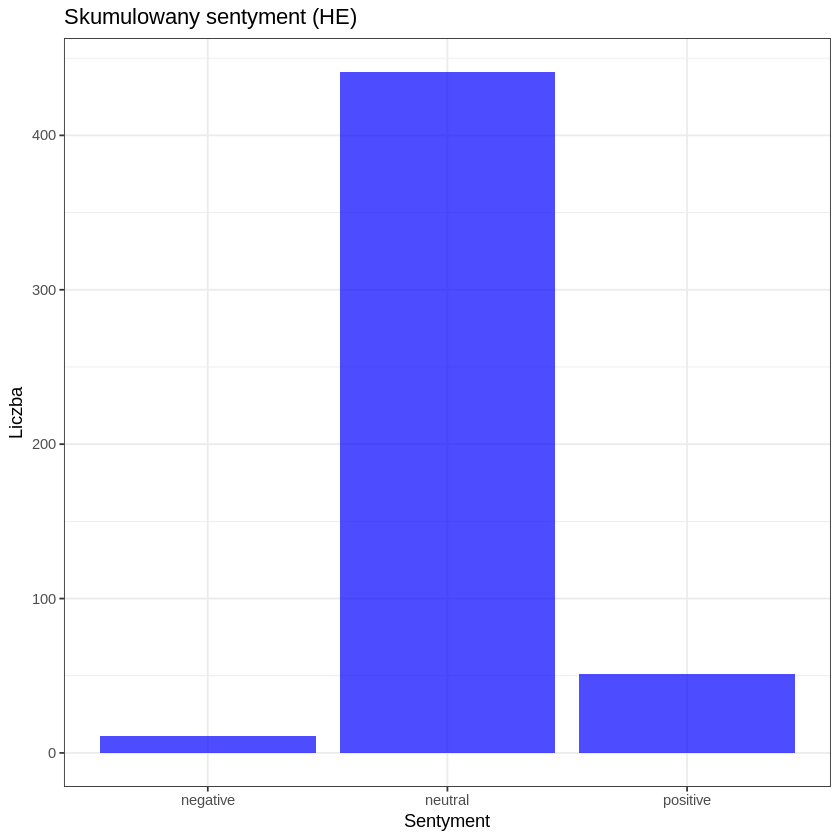

In [26]:
### S≈Çownik HE (Henry‚Äôs Financial dictionary) ----
#
# zawiera listƒô s≈Ç√≥w pozytywnych i negatywnych
# zgodnych z finansowym s≈Çownikiem "Henry 2008"
# pierwszy, jaki powsta≈Ç w wyniku analizy komunikat√≥w prasowych
# dotyczƒÖcych zysk√≥w w bran≈ºy telekomunikacyjnej i us≈Çug IT
# DictionaryHE


# Wczytaj s≈Çownik HE
# data(DictionaryHE)
# summary(DictionaryHE)


# Konwersja ciƒÖg≈Çych warto≈õci sentymentu
# na odpowiadajƒÖce im warto≈õci kierunkowe
# zgodnie ze s≈Çownikiem HE
sentimentHE <- convertToDirection(sentiment$SentimentHE)


# Wykres skumulowanego sentymentu kierunkowego
# plot(sentimentHE)


# Ten sam wykres w ggplot2:
# Konwersja do ramki danych (ggplot wizualizuje ramki danych)
df_HE <- data.frame(index = seq_along(sentimentHE), value = sentimentHE, Dictionary = "HE")

# Usuniƒôcie wierszy, kt√≥re zawierajƒÖ NA
df_HE <- na.omit(df_HE)

ggplot(df_HE, aes(x = value)) +
  geom_bar(fill = "blue", alpha = 0.7) +
  labs(title = "Skumulowany sentyment (HE)",
       x = "Sentyment",
       y = "Liczba") +
  theme_bw()

### S≈Çownik LM (Loughran-McDonald Financial dictionary) ----

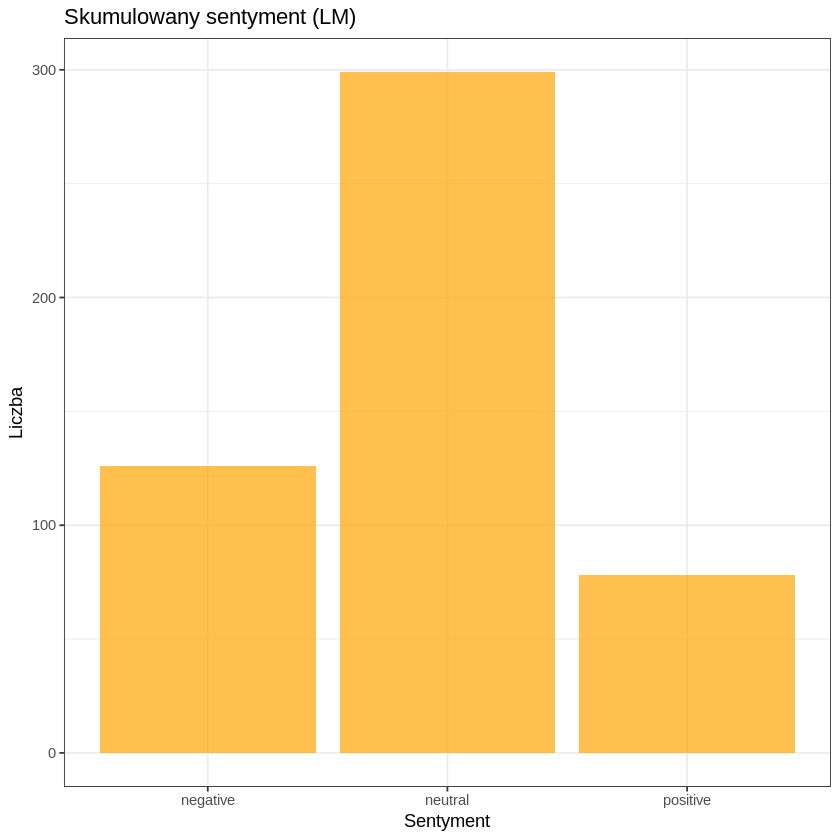

In [27]:
### S≈Çownik LM (Loughran-McDonald Financial dictionary) ----
#
# zawiera listƒô s≈Ç√≥w pozytywnych i negatywnych oraz zwiƒÖzanych z niepewno≈õciƒÖ
# zgodnych z finansowym s≈Çownikiem Loughran-McDonald
# DictionaryLM


# Wczytaj s≈Çownik LM
# data(DictionaryLM)
# summary(DictionaryLM)


# Konwersja ciƒÖg≈Çych warto≈õci sentymentu
# na odpowiadajƒÖce im warto≈õci kierunkowe
# zgodnie ze s≈Çownikiem LM
sentimentLM <- convertToDirection(sentiment$SentimentLM)


# Wykres skumulowanego sentymentu kierunkowego
# plot(sentimentLM)


# Ten sam wykres w ggplot2:
# Konwersja do ramki danych (ggplot wizualizuje ramki danych)
df_LM <- data.frame(index = seq_along(sentimentLM), value = sentimentLM, Dictionary = "LM")

# Usuniƒôcie wierszy, kt√≥re zawierajƒÖ NA
df_LM <- na.omit(df_LM)

ggplot(df_LM, aes(x = value)) +
  geom_bar(fill = "orange", alpha = 0.7) +
  labs(title = "Skumulowany sentyment (LM)",
       x = "Sentyment",
       y = "Liczba") +
  theme_bw()

### S≈Çownik QDAP (Quantitative Discourse Analysis Package) ----

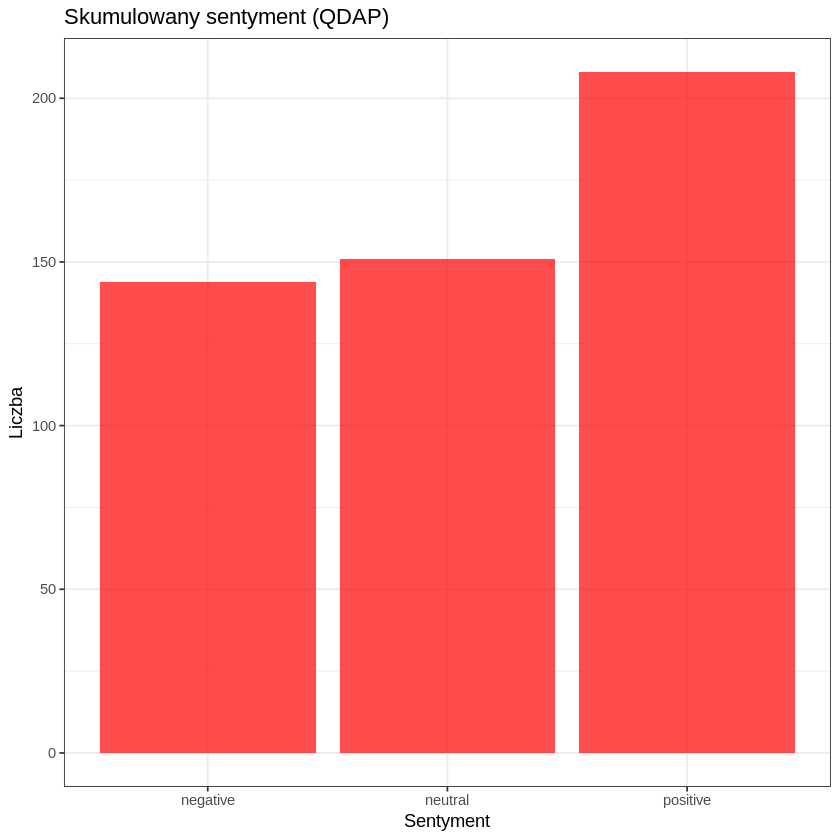

In [28]:
### S≈Çownik QDAP (Quantitative Discourse Analysis Package) ----
#
# zawiera listƒô s≈Ç√≥w pozytywnych i negatywnych
# do analizy dyskursu


# Wczytaj s≈Çownik QDAP
qdap <- loadDictionaryQDAP()
# summary(qdap)


# Konwersja ciƒÖg≈Çych warto≈õci sentymentu
# na odpowiadajƒÖce im warto≈õci kierunkowe
# zgodnie ze s≈Çownikiem QDAP
sentimentQDAP <- convertToDirection(sentiment$SentimentQDAP)


# Wykres skumulowanego sentymentu kierunkowego
# plot(sentimentQDAP)


# Ten sam wykres w ggplot2:
# Konwersja do ramki danych (ggplot wizualizuje ramki danych)
df_QDAP <- data.frame(index = seq_along(sentimentQDAP), value = sentimentQDAP, Dictionary = "QDAP")

# Usuniƒôcie wierszy, kt√≥re zawierajƒÖ NA
df_QDAP <- na.omit(df_QDAP)

ggplot(df_QDAP, aes(x = value)) +
  geom_bar(fill = "red", alpha = 0.7) +
  labs(title = "Skumulowany sentyment (QDAP)",
       x = "Sentyment",
       y = "Liczba") +
  theme_bw()

# Por√≥wnanie sentymentu na podstawie r√≥≈ºnych s≈Çownik√≥w ----

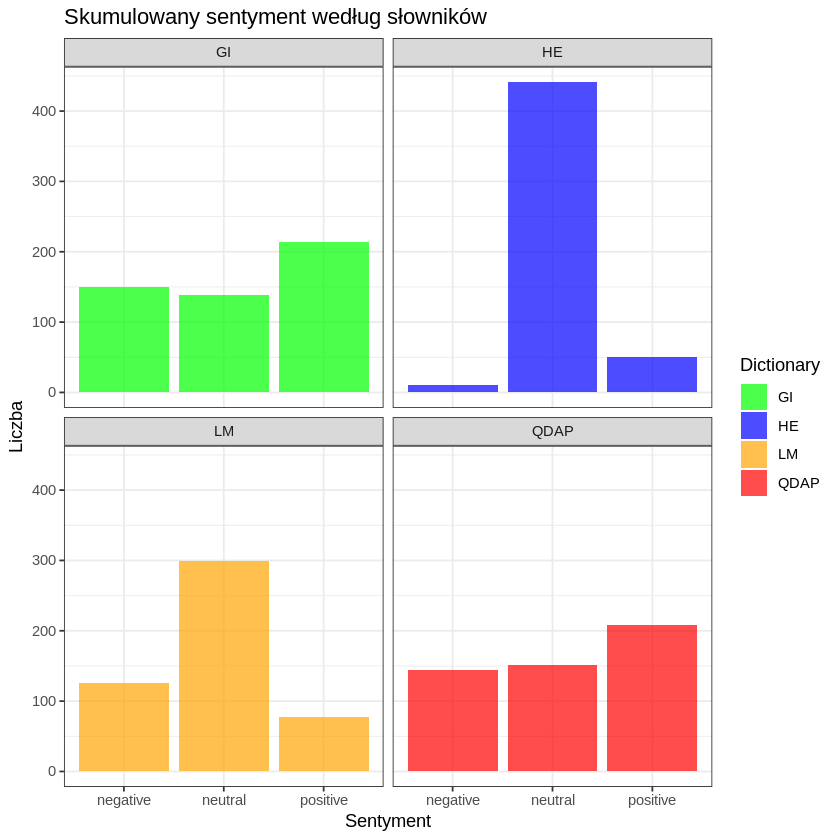

In [29]:
# Minimalistycznie
# plot(convertToDirection(sentiment$SentimentGI))
# plot(convertToDirection(sentiment$SentimentHE))
# plot(convertToDirection(sentiment$SentimentLM))
# plot(convertToDirection(sentiment$SentimentQDAP))


# Wizualnie lepsze w ggplot2
# Po≈ÇƒÖczenie poszczeg√≥lnych ramek w jednƒÖ ramkƒô
df_all <- bind_rows(df_GI, df_HE, df_LM, df_QDAP)

# Tworzenie wykresu z podzia≈Çem na s≈Çowniki
ggplot(df_all, aes(x = value, fill = Dictionary)) +
  geom_bar(alpha = 0.7) +
  labs(title = "Skumulowany sentyment wed≈Çug s≈Çownik√≥w",
       x = "Sentyment",
       y = "Liczba") +
  theme_bw() +
  facet_wrap(~Dictionary) +  # Podzia≈Ç na cztery osobne wykresy
  scale_fill_manual(values = c("GI" = "green",
                               "HE" = "blue",
                               "LM" = "orange",
                               "QDAP" = "red" ))


# Agregowanie sentymentu z r√≥≈ºnych s≈Çownik√≥w w czasie ----

In [30]:
# Sprawdzenie ilo≈õci obserwacji
length(sentiment[,1])


# Utworzenie ramki danych
df_all <- data.frame(sentence=1:length(sentiment[,1]),
                     GI=sentiment$SentimentGI,
                     HE=sentiment$SentimentHE,
                     LM=sentiment$SentimentLM,
                     QDAP=sentiment$SentimentQDAP)



# USUNIƒòCIE BRAKUJƒÑCYCH WARTO≈öCI
# gdy≈º warto≈õci NA (puste) uniemo≈ºliwiajƒÖ generowanie wykresu w ggplot
#

# Usuniƒôcie warto≈õci NA
# Wybranie tylko niekompletnych przypadk√≥w:
puste <- df_all[!complete.cases(df_all), ]


# Usuniƒôcie pustych obserwacji
# np. dla zmiennej QDAP (wszystkie majƒÖ NA)
df_all <- df_all[!is.na(df_all$QDAP), ]


# Sprawdzenie, czy warto≈õci NA zosta≈Çy usuniƒôte
# wtedy puste2 ma 0 wierszy:
puste2 <- df_all[!complete.cases(df_all), ]
puste2

[1] 503

sentence GI HE LM QDAP

# Wykresy przedstawiajƒÖce ewolucjƒô sentymentu w czasie ----

Warning message:
‚ÄúUsing `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
‚Ñπ Please use `linewidth` instead.‚Äù


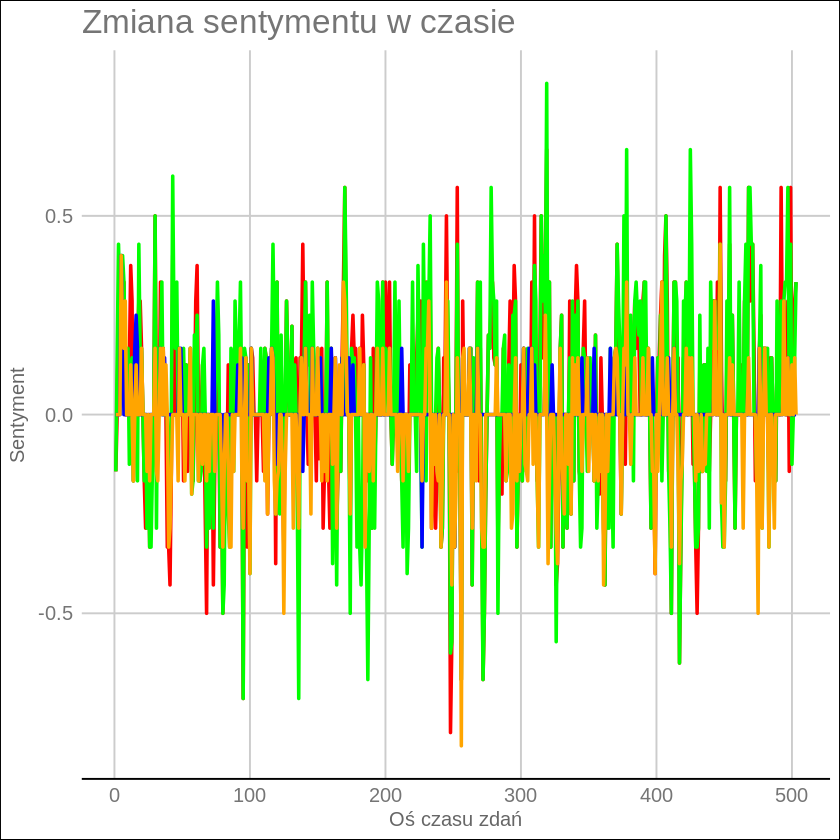

In [31]:
# Wykresy przedstawiajƒÖce ewolucjƒô sentymentu w czasie ----

ggplot(df_all, aes(x=sentence, y=QDAP)) +
  geom_line(color="red", size=1) +
  geom_line(aes(x=sentence, y=GI), color="green", size=1) +
  geom_line(aes(x=sentence, y=HE), color="blue", size=1) +
  geom_line(aes(x=sentence, y=LM), color="orange", size=1) +
  labs(x = "O≈õ czasu zda≈Ñ", y = "Sentyment") +
  theme_gdocs() +
  ggtitle("Zmiana sentymentu w czasie")

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


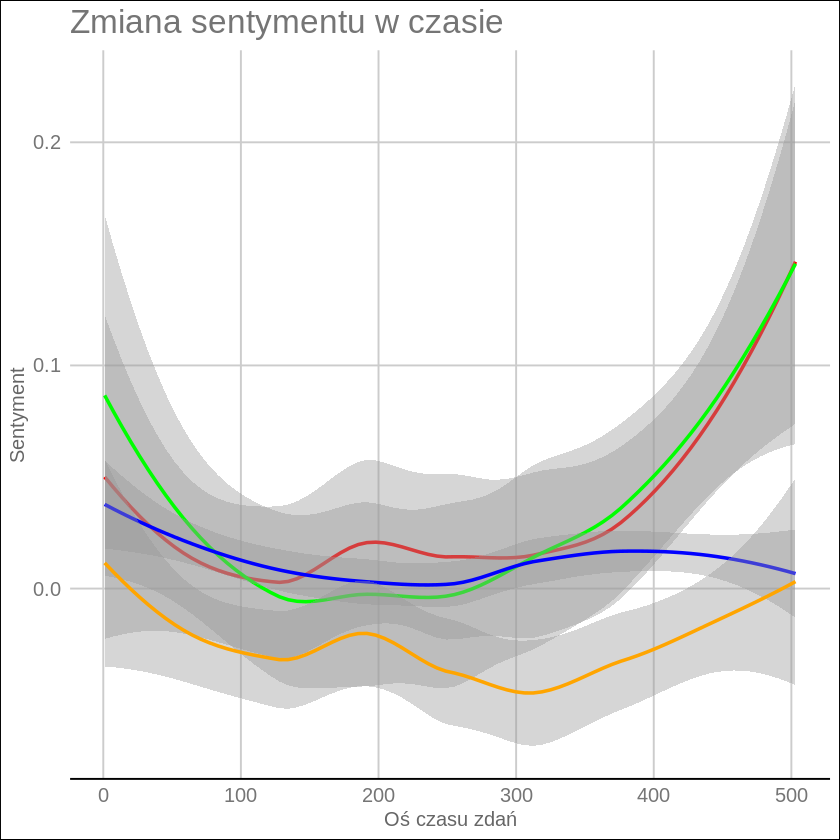

In [32]:
ggplot(df_all, aes(x=sentence, y=QDAP)) +
  geom_smooth(color="red") +
  geom_smooth(aes(x=sentence, y=GI), color="green") +
  geom_smooth(aes(x=sentence, y=HE), color="blue") +
  geom_smooth(aes(x=sentence, y=LM), color="orange") +
  labs(x = "O≈õ czasu zda≈Ñ", y = "Sentyment") +
  theme_gdocs() +
  ggtitle("Zmiana sentymentu w czasie")